# Tutorial: GMM Postprocessing and Hard Labeling 

The following jupyter notebook focuses on the GMM postprocessing and hard labeling approach considered in the article of this package. The GMM postprocessing allows mapping scores to probabilities. During hard labeling, we aim to assign each cell a state based on the signature scores associated with the corresponding state. Depending on our data assumptions, we either consider that a cell belongs to one of the signature associated states or none of them. Therefore, we will consider two scenarios on the preprocessed PBMC dataset also used in the `basic_usage.ipynb` jupyter notebook. :
1. We score **three signatures**, one associated with each of the three available cell states: B-, Monocytes, and NK-cells. Since each cell belongs to one of the three cell-types, we select **K=3** during  GMM postprocessing. Finally, we can assign the cell state associated with the highest-scoring/ highest probability signature to a cell. 
2. We score **two signatures** associated with two of the three available cell states. Now we assume that a cell can belong to either one of the cell states we score **or** to none. Therefore we select **K=2+1** during GMM postprocessing (+ 1 being the remaining class). Hard labeling on probabilities is based on selecting the cell state associated with the signature with the highest probability. The process on scores, however, requires finding the correct signature-specific thresholds for each signature and then assigning a cell with the state of the remaining class if its scores are below the signature-specific thresholds. See below for more information. 

*We will use the scored data from the `basic_usage.ipynb` jupyter notebook.*

**Structure**:
- Loading preprocessed and scored data 
- GMM Postprocessing 
- Hard Labeling

In [1]:
import numpy as np 
import scanpy as sc
import pandas as pd
from sklearn.metrics import f1_score

from scipy.signal import argrelmin
import matplotlib.pyplot as plt
import seaborn as sns

from signaturescoring.scoring_methods.gmm_postprocessing import GMMPostprocessor

sc.settings.verbosity = 0

## Load preprocessed and scored data

In [2]:
adata = sc.read_h5ad('tut_data/pp_pbmc_b_mono_nk_scored.h5ad')

## To avoid errors 
if 'log1p' in adata.uns_keys():
    adata.uns['log1p']['base'] = None
else:
    adata.uns['log1p'] = {'base': None}

In [3]:
adata.obs['celltype.l1'].value_counts()

Mono    43553
NK      14408
B       10613
Name: celltype.l1, dtype: int64

## GMM Postprocessing 
As previously explained we would like to map the signature scores to probabilities using a GMM. The `GMMPostprocessor` first trains a GMM on the passed score columns (3 columns in scenario 1, 2 columns in scenario 2). Then we assign a cluster to a cell state based on the correlation of the pobabilities and the signature scores.

### Scenario 1: Three signatures

In [4]:
scoring_names_3_sigs = list(adata.obs.columns[-(8*3):])
scoring_names_3_sigs

['ANS_B',
 'ANS_Mono',
 'ANS_NK',
 'Scanpy_B',
 'Scanpy_Mono',
 'Scanpy_NK',
 'Tirosh_B',
 'Tirosh_Mono',
 'Tirosh_NK',
 'Tirosh_AG_B',
 'Tirosh_AG_Mono',
 'Tirosh_AG_NK',
 'Tirosh_LVG_B',
 'Tirosh_LVG_Mono',
 'Tirosh_LVG_NK',
 'Jasmine_LH_B',
 'Jasmine_LH_Mono',
 'Jasmine_LH_NK',
 'Jasmine_OR_B',
 'Jasmine_OR_Mono',
 'Jasmine_OR_NK',
 'UCell_B',
 'UCell_Mono',
 'UCell_NK']

In [5]:
## Helper list with colum names 
scoring_names_3_gmm = []

In [6]:
# For the THREE cell state signature score colums of each scoring method we fit a 
# GMM to convert the scores into probabilities
for i in range(0, len(scoring_names_3_sigs), 3):
    
    # initialize GMMPostprocessor
    gmm_post = GMMPostprocessor(
        n_components=3
    )
    
    # fit the GMM model on the 3 columns of the scores 
    store_name_pred, store_names_proba, _ = gmm_post.fit_and_predict(adata, scoring_names_3_sigs[i:(i+3)])
    
    # assign clusters to signatures 
    assignments = gmm_post.assign_clusters_to_signatures(adata, scoring_names_3_sigs[i:(i+3)], store_names_proba, plot=False)
    print(assignments)
    
    for key, val in assignments.items():
        adata.obs[key+'_gmm_3sigs'] = adata.obs[val].copy()
        scoring_names_3_gmm.append(key+'_gmm_3sigs')

{'ANS_B': 'ANS_2_GMM_proba', 'ANS_Mono': 'ANS_0_GMM_proba', 'ANS_NK': 'ANS_1_GMM_proba'}
{'Scanpy_B': 'Scanpy_2_GMM_proba', 'Scanpy_Mono': 'Scanpy_1_GMM_proba', 'Scanpy_NK': 'Scanpy_0_GMM_proba'}
{'Tirosh_B': 'Tirosh_2_GMM_proba', 'Tirosh_Mono': 'Tirosh_1_GMM_proba', 'Tirosh_NK': 'Tirosh_0_GMM_proba'}
{'Tirosh_AG_B': 'Tirosh_AG_2_GMM_proba', 'Tirosh_AG_Mono': 'Tirosh_AG_0_GMM_proba', 'Tirosh_AG_NK': 'Tirosh_AG_1_GMM_proba'}
{'Tirosh_LVG_B': 'Tirosh_LVG_2_GMM_proba', 'Tirosh_LVG_Mono': 'Tirosh_LVG_0_GMM_proba', 'Tirosh_LVG_NK': 'Tirosh_LVG_1_GMM_proba'}
{'Jasmine_LH_B': 'Jasmine_LH_2_GMM_proba', 'Jasmine_LH_Mono': 'Jasmine_LH_1_GMM_proba', 'Jasmine_LH_NK': 'Jasmine_LH_0_GMM_proba'}
{'Jasmine_OR_B': 'Jasmine_OR_2_GMM_proba', 'Jasmine_OR_Mono': 'Jasmine_OR_1_GMM_proba', 'Jasmine_OR_NK': 'Jasmine_OR_0_GMM_proba'}
{'UCell_B': 'UCell_0_GMM_proba', 'UCell_Mono': 'UCell_1_GMM_proba', 'UCell_NK': 'UCell_2_GMM_proba'}


### Scenario 2: Two signatures

In [7]:
scoring_names_2_sigs = [x for x in scoring_names_3_sigs if 'NK' not in x] 
scoring_names_2_sigs

['ANS_B',
 'ANS_Mono',
 'Scanpy_B',
 'Scanpy_Mono',
 'Tirosh_B',
 'Tirosh_Mono',
 'Tirosh_AG_B',
 'Tirosh_AG_Mono',
 'Tirosh_LVG_B',
 'Tirosh_LVG_Mono',
 'Jasmine_LH_B',
 'Jasmine_LH_Mono',
 'Jasmine_OR_B',
 'Jasmine_OR_Mono',
 'UCell_B',
 'UCell_Mono']

In [8]:
## Helper list with colum names 
scoring_names_2_gmm = []

In [9]:
# For the TWO cell state signature score colums of each scoring method we fit a 
# GMM to convert the scores into probabilities

for i in range(0, len(scoring_names_2_sigs), 2):
    # initialize GMMPostprocessor
    gmm_post = GMMPostprocessor(
        n_components=3
    )
    
    # fit the GMM model on the 2 columns of the scores 
    store_name_pred, store_names_proba, _ = gmm_post.fit_and_predict(adata, scoring_names_2_sigs[i:(i+2)])
    
    # assign clusters to signatures
    assignments = gmm_post.assign_clusters_to_signatures(adata, scoring_names_2_sigs[i:(i+2)], store_names_proba, plot=False)
    
    print(assignments)
    for key, val in assignments.items():
        if key =='rest':
            continue
        adata.obs[key+'_gmm_2sigs'] = adata.obs[val].copy()
        scoring_names_2_gmm.append(key+'_gmm_2sigs')
    
    curr_name = '_'.join(scoring_names_2_sigs[i].split('_')[0:-1])
    adata.obs[curr_name +'_NK_gmm_2sigs'] = adata.obs[next(iter(assignments['rest']))].copy()
    scoring_names_2_gmm.append(curr_name +'_NK_gmm_2sigs')

{'ANS_B': 'ANS_2_GMM_proba', 'ANS_Mono': 'ANS_1_GMM_proba', 'rest': {'ANS_0_GMM_proba'}}
{'Scanpy_B': 'Scanpy_2_GMM_proba', 'Scanpy_Mono': 'Scanpy_1_GMM_proba', 'rest': {'Scanpy_0_GMM_proba'}}
{'Tirosh_B': 'Tirosh_1_GMM_proba', 'Tirosh_Mono': 'Tirosh_0_GMM_proba', 'rest': {'Tirosh_2_GMM_proba'}}
{'Tirosh_AG_B': 'Tirosh_AG_1_GMM_proba', 'Tirosh_AG_Mono': 'Tirosh_AG_0_GMM_proba', 'rest': {'Tirosh_AG_2_GMM_proba'}}
{'Tirosh_LVG_B': 'Tirosh_LVG_2_GMM_proba', 'Tirosh_LVG_Mono': 'Tirosh_LVG_1_GMM_proba', 'rest': {'Tirosh_LVG_0_GMM_proba'}}
{'Jasmine_LH_B': 'Jasmine_LH_1_GMM_proba', 'Jasmine_LH_Mono': 'Jasmine_LH_2_GMM_proba', 'rest': {'Jasmine_LH_0_GMM_proba'}}
{'Jasmine_OR_B': 'Jasmine_OR_1_GMM_proba', 'Jasmine_OR_Mono': 'Jasmine_OR_0_GMM_proba', 'rest': {'Jasmine_OR_2_GMM_proba'}}
{'UCell_B': 'UCell_1_GMM_proba', 'UCell_Mono': 'UCell_0_GMM_proba', 'rest': {'UCell_2_GMM_proba'}}


In [10]:
## remove all unused obs columns
adata.obs.drop(columns=[x for x in adata.obs.columns if ('gmm' in x.lower()) and ('sigs' not in x.lower())], 
               inplace=True)

### Visualizing GMM pobabilites

In [11]:
sc.tl.pca(adata)
sc.pp.neighbors(adata)
sc.tl.umap(adata)

/local/lciernik/miniconda3/envs/scrna-env/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/local/lciernik/miniconda3/envs/scrna-env/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/local/lciernik/miniconda3/envs/scrna-env/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


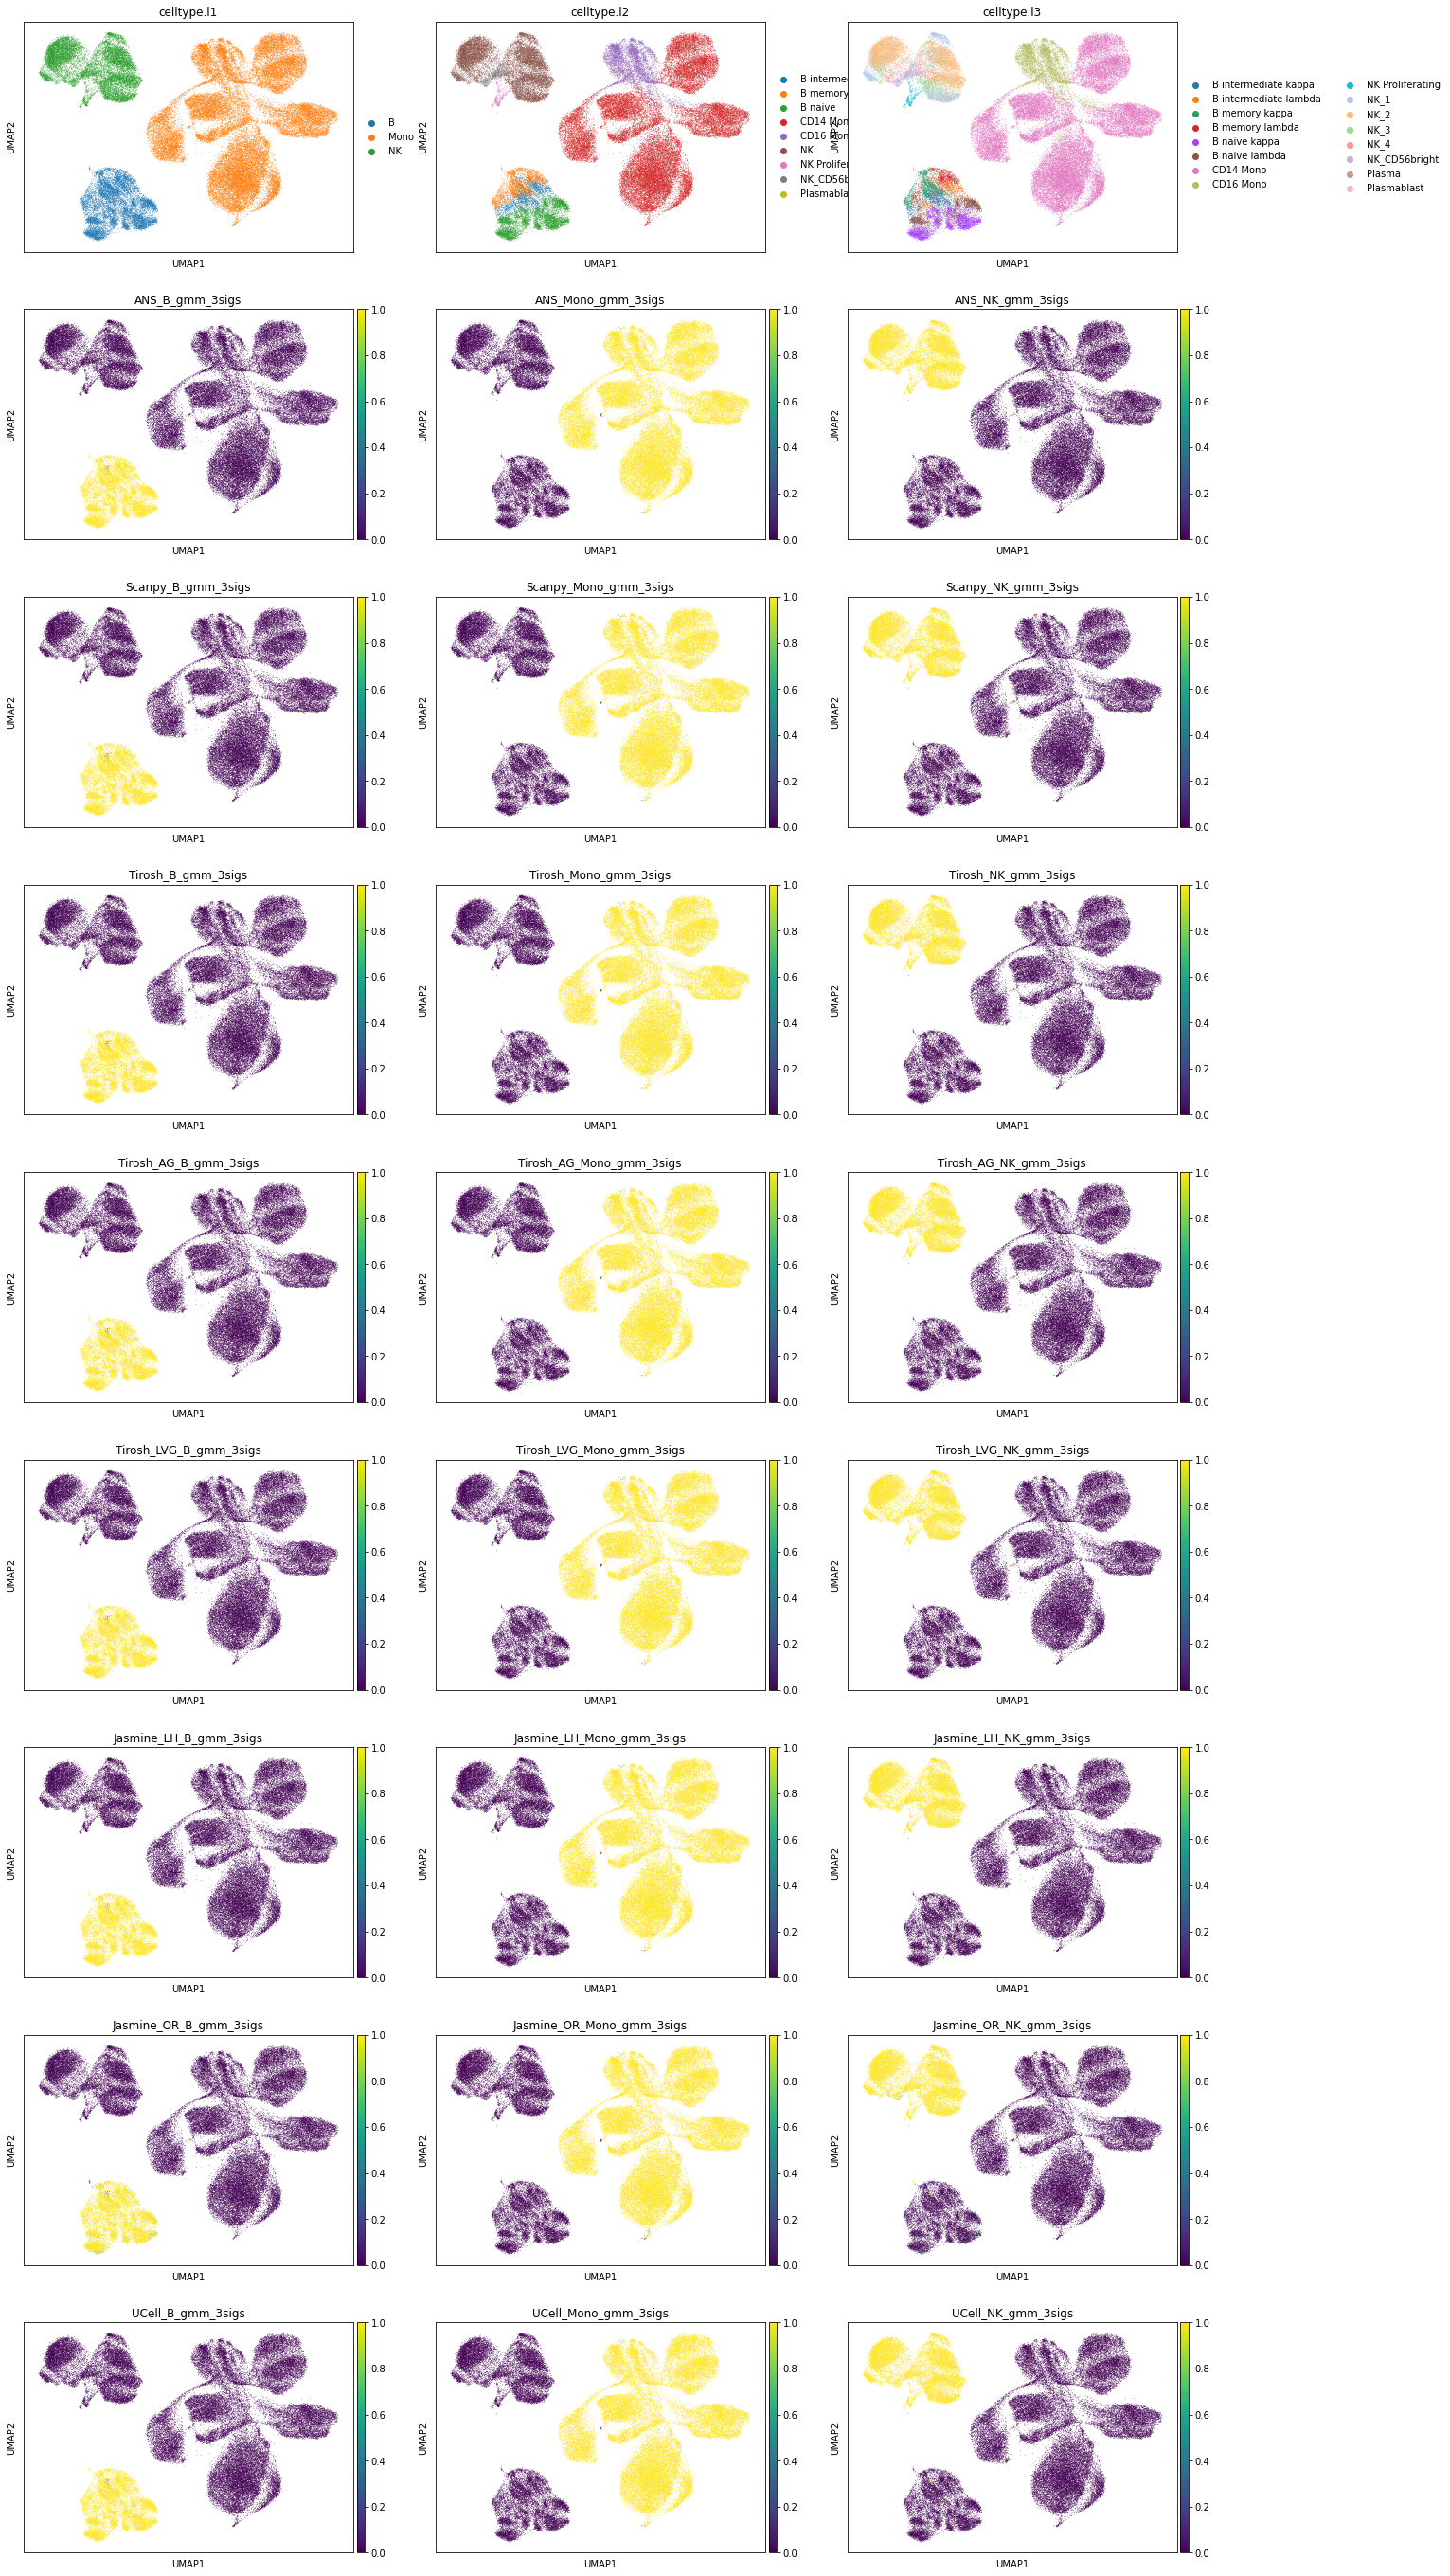

In [12]:
# scenario 1 probabilities
sc.pl.umap(adata, color=['celltype.l1', 'celltype.l2', 'celltype.l3']+scoring_names_3_gmm, ncols=3)

/local/lciernik/miniconda3/envs/scrna-env/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/local/lciernik/miniconda3/envs/scrna-env/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/local/lciernik/miniconda3/envs/scrna-env/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


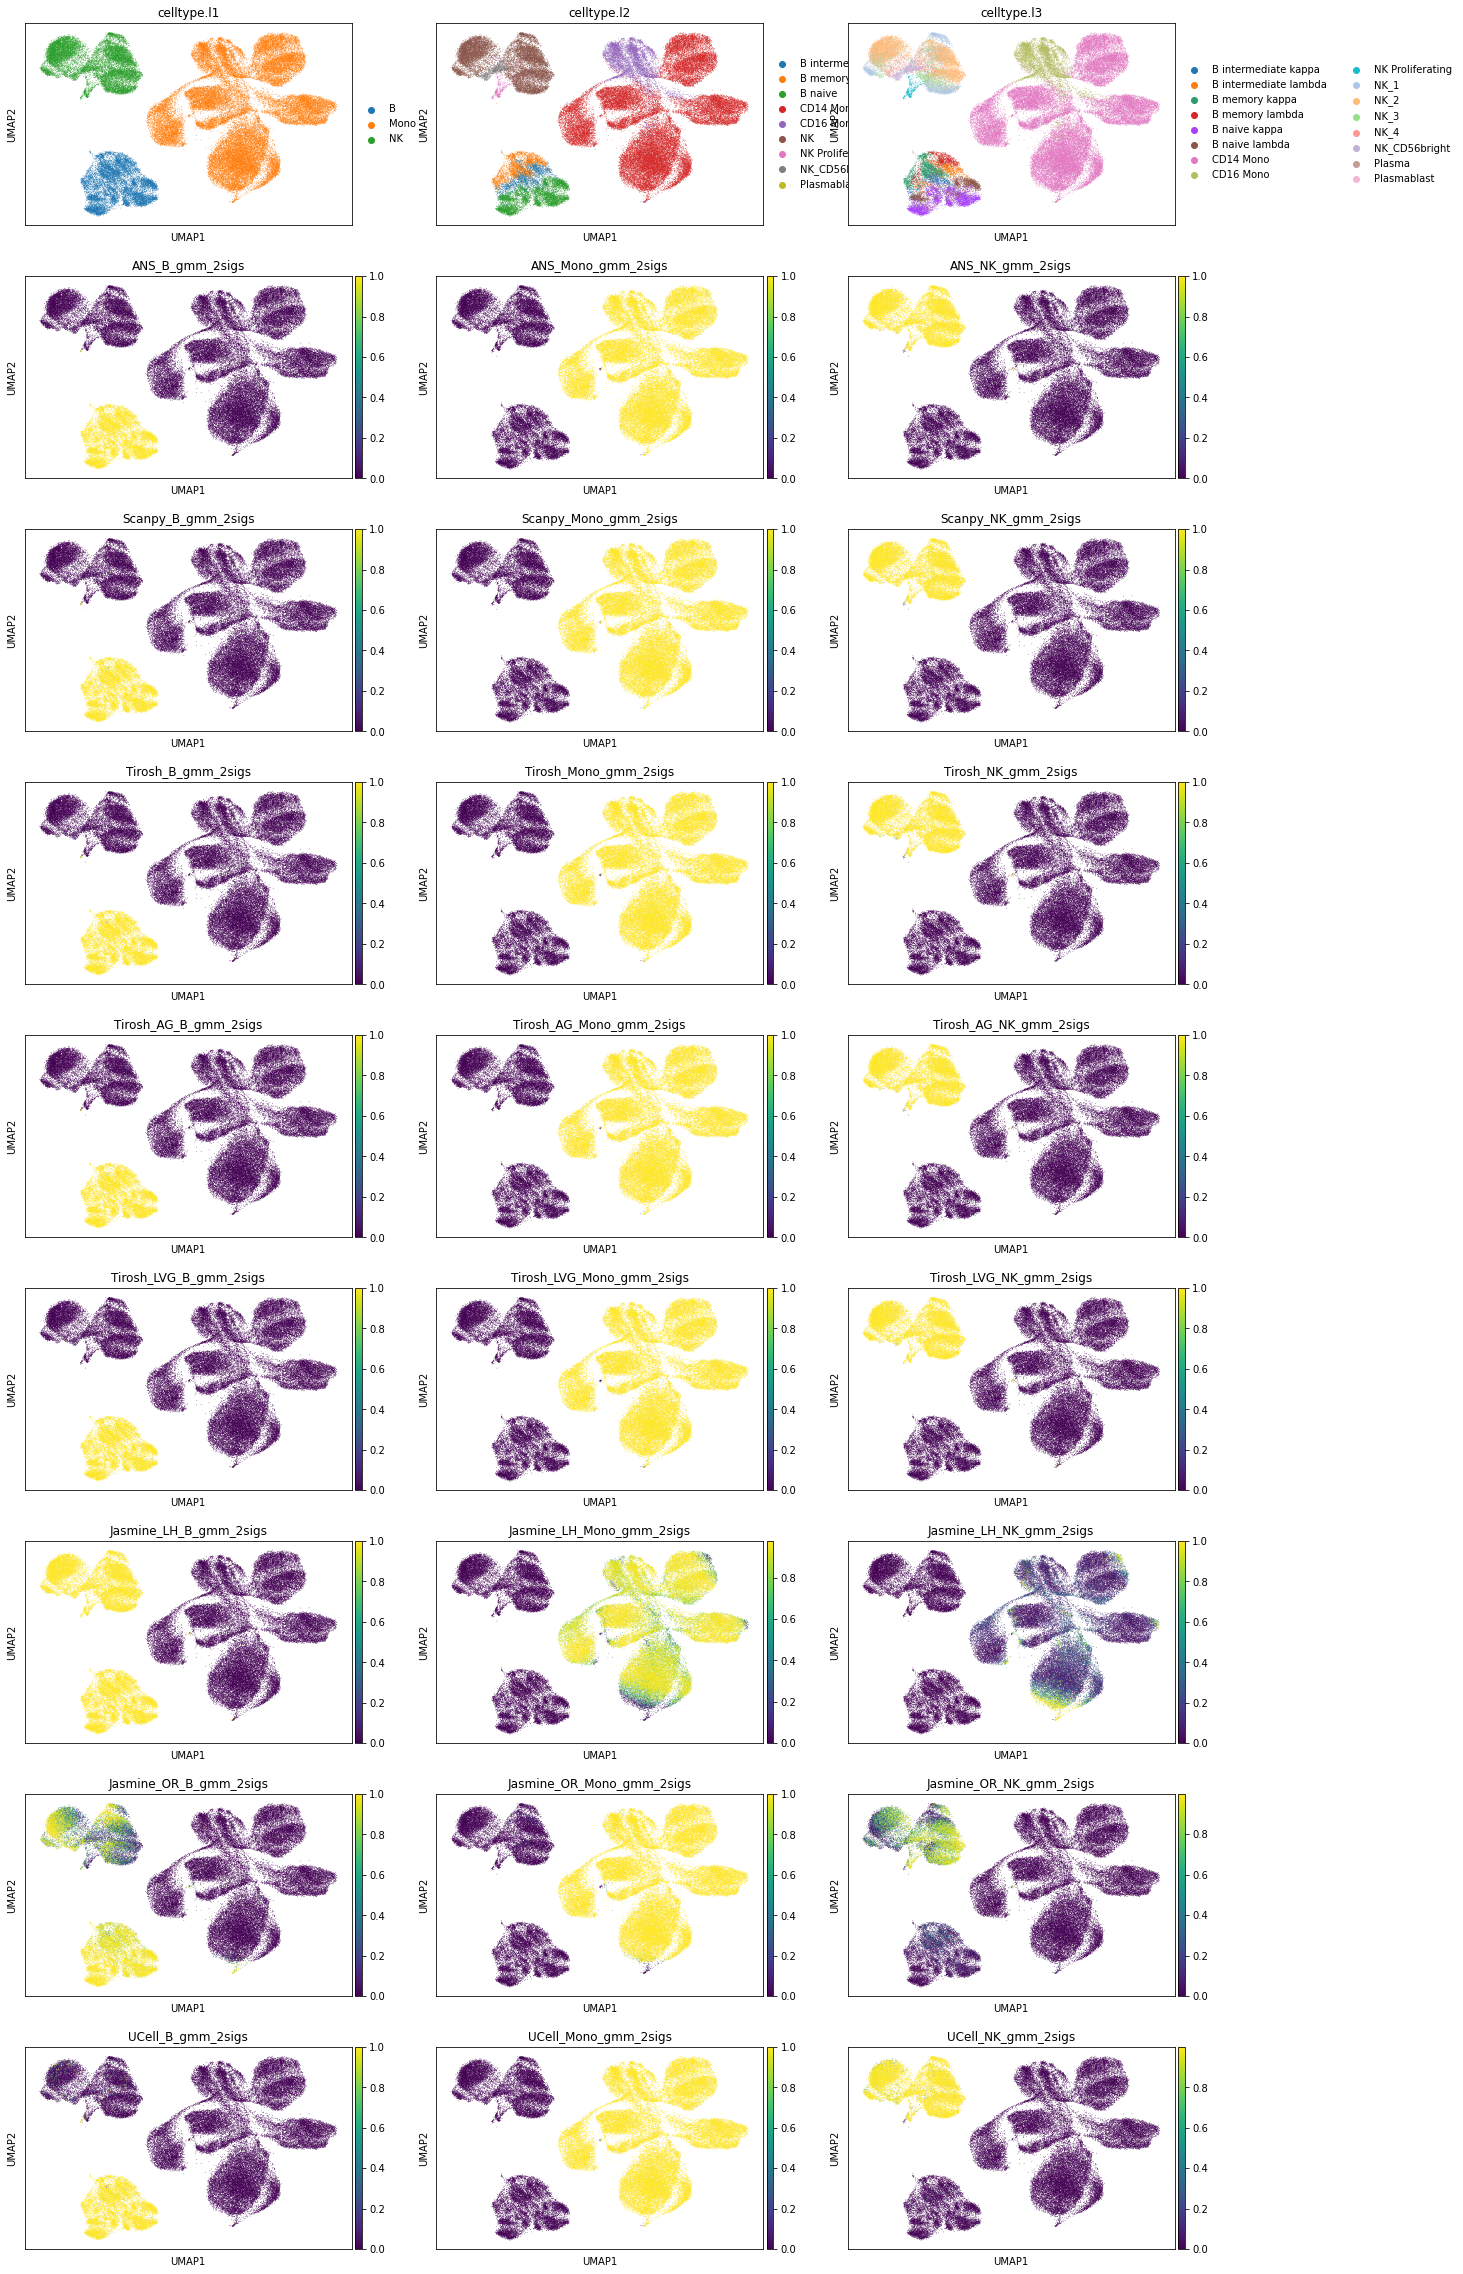

In [13]:
# scenario 2 probabilities
sc.pl.umap(adata, color=['celltype.l1', 'celltype.l2', 'celltype.l3']+scoring_names_2_gmm, ncols=3)

## Hard Labeling

### Scenario 1: Three signatures
As mentioned in the introduction of this jupyter notebook, we can apply hard labeling in this scenario by assigning the cell state associated with the highest-scoring signature/signature with the highest probability to each cell.  

For both, scores and probabilities, we select the score/probability columns belonging to each scoring method and assign the label to a cell with the rowwise max.  

In [14]:
all_pred_cols_1 = []

##### Scores 

In [15]:
for i in range(0, len(scoring_names_3_sigs), 3):
    # get the name of the scoring method
    method = scoring_names_3_sigs[i].rsplit('_',1)[0]
    # select argmax for each cell (each row)
    curr_val = adata.obs[scoring_names_3_sigs[i:(i+3)]].idxmax(axis="columns")
    curr_val = curr_val.apply(lambda x: x.rsplit('_',1)[1])
    # store prediction 
    adata.obs[f'{method}_scores_HL_3sigs'] = curr_val
    all_pred_cols_1.append(f'{method}_scores_HL_3sigs')

##### Probabilities 

In [16]:
for i in range(0, len(scoring_names_3_gmm), 3):
    # get the name of the scoring method
    method = scoring_names_3_gmm[i].rsplit('_',3)[0]
    # select argmax for each cell (each row)
    curr_val= adata.obs[scoring_names_3_gmm[i:(i+3)]].idxmax(axis="columns")
    curr_val=curr_val.apply(lambda x: x.rsplit('_',3)[1])
    # store prediction 
    adata.obs[f'{method}_probabilities_HL_3sigs'] = curr_val
    all_pred_cols_1.append(f'{method}_probabilities_HL_3sigs')

### Scenario 2: Two signatures
In the second scenario, hard labeling is more challenging based on scores than on probabilities. Hard labeling on probabilities is done equivalently to scenario 1.

In [17]:
all_pred_cols_2 = []

##### Scores 
When hard-labeling on scores in this scenario, we require to find the adequate score-thresholds for each signature. After selecting a B- and Monocyte-threshold, we can simply assign cells with scores below both thresholds as NK-cells. 
To find the thresholds we find the minima in the score histograms of both signatures. We will visualize the density plots to identify theses thresholds.

In [18]:
def plot_score_distributions(method, scores_B, scores_Mono):
    plt.figure(figsize=(10,6))
    hist_one = np.histogram(scores_B.values, bins = 100, density=True)
    x_min_B = argrelmin(hist_one[0], order=3)
    plt.plot(hist_one[0])
    for e in x_min_B[0]:
        plt.axvline(e, c='r', alpha=0.5)
        plt.text(e,max(hist_one[0]),e)
    plt.axvline(e, c='r', alpha=0.5, label=f'mins B scores dist')


    hist_two = np.histogram(scores_Mono.values, bins = 100, density=True)
    x_min_Mono = argrelmin(hist_two[0], order=3)
    plt.plot(hist_two[0])
    plt.title(method, fontsize=18)
    for e in x_min_Mono[0]:
        plt.axvline(e, c='g', alpha=0.5)
        plt.text(e,max(hist_two[0]),e)
    plt.axvline(e, c='g', alpha=0.5, label=f'mins Mono scores dist')
    plt.legend(bbox_to_anchor=(1, 0.5))
    plt.show()
    
    
def get_score_threshs(selected_thresh, scores_B, scores_Mono):
    hist_one = np.histogram(scores_B.values, bins = 100, density=True)
    hist_two = np.histogram(scores_Mono.values, bins = 100, density=True)
    thresh_one = hist_one[1][selected_thresh[0]]          
    thresh_two = hist_two[1][selected_thresh[1]]
    return [thresh_one, thresh_two]

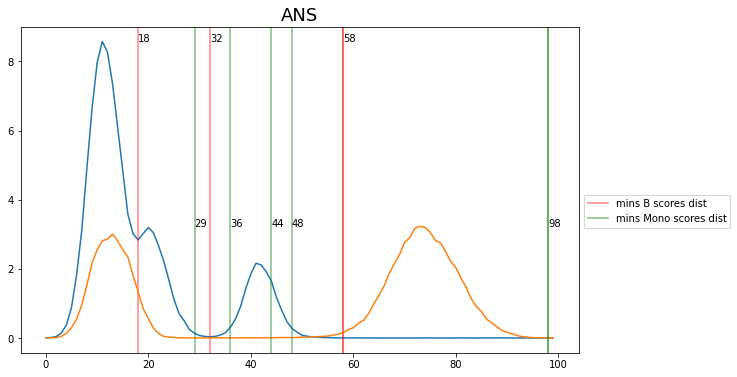

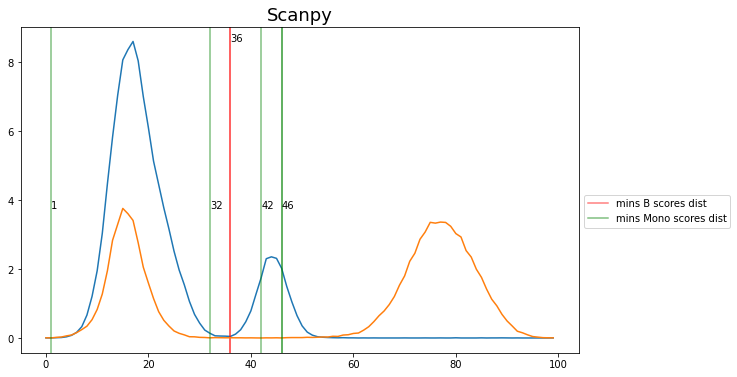

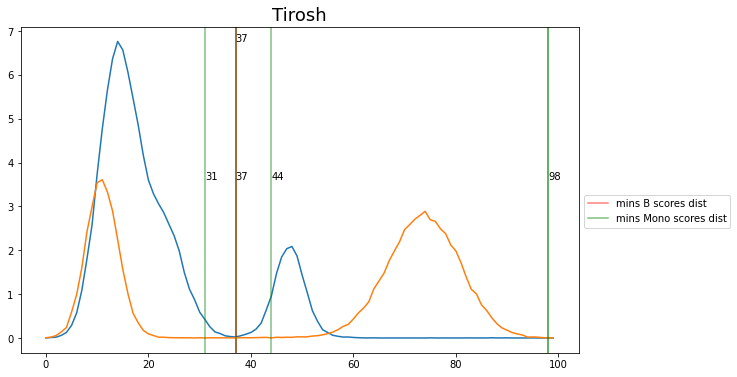

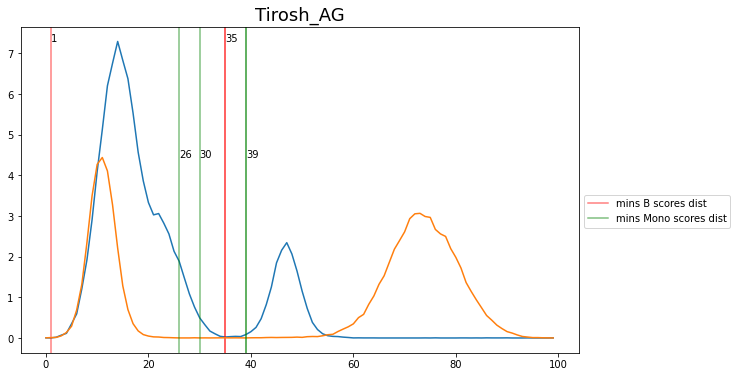

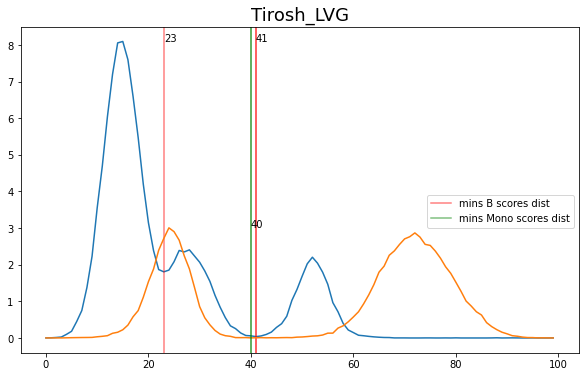

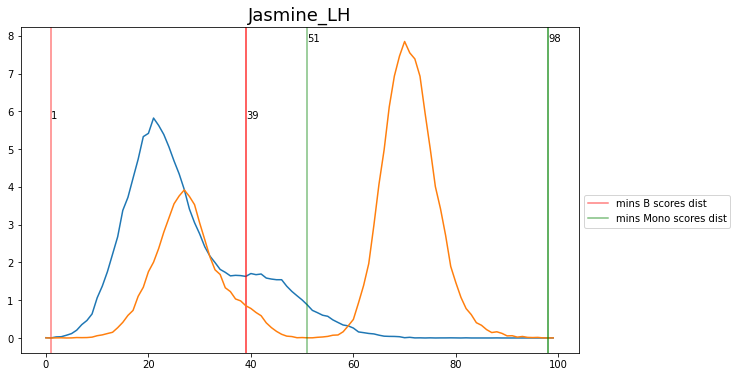

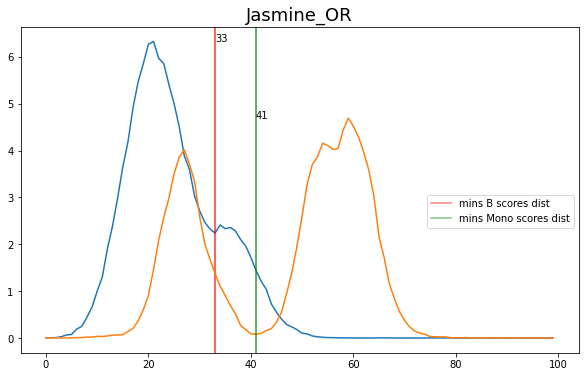

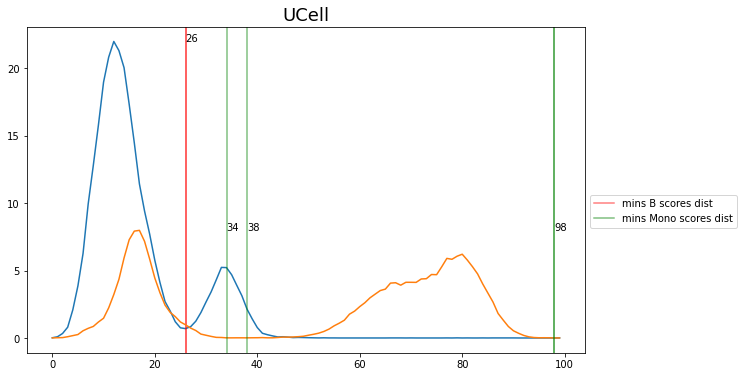

In [19]:
for i in range(0, len(scoring_names_2_sigs), 2):
    method = scoring_names_2_sigs[i].rsplit('_',1)[0]
    # convert threshs to score threshs 
    B_scores = adata.obs[scoring_names_2_sigs[i]]
    M_scores = adata.obs[scoring_names_2_sigs[i+1]]
    plot_score_distributions(method, B_scores, M_scores)

In [20]:
## Select manually fromg the figures the disered thresholds and convert them then to score thresholds
selected_thresh = {
    'ANS': [32, 36],
    'Scanpy': [36, 42],
    'Tirosh': [37, 37],
    'Tirosh_AG': [35, 30],
    'Tirosh_LVG': [41, 40],
    'Jasmine_LH': [39, 51],
    'Jasmine_OR': [33, 41],
    'UCell': [26, 38],
}

In [21]:
for (method, threshs), i in zip(selected_thresh.items(), range(0, len(scoring_names_2_sigs), 2)):
    # convert threshs to score threshs 
    B_scores = adata.obs[scoring_names_2_sigs[i]]
    M_scores = adata.obs[scoring_names_2_sigs[i+1]]
    [B_thresh, M_thresh] = get_score_threshs(threshs, B_scores, M_scores)
    
    # assign cell state to cells.
    curr_val = adata.obs[scoring_names_2_sigs[i:(i+2)]].idxmax(axis="columns")
    curr_val = curr_val.apply(lambda x: x.rsplit('_',1)[1])
    curr_val.loc[(B_scores<B_thresh)&((M_scores<M_thresh))] = 'NK'
    # store prediction 
    adata.obs[f'{method}_scores_HL_2sigs'] = curr_val
    all_pred_cols_2.append(f'{method}_scores_HL_2sigs')

##### Probabilities 

In [22]:
for i in range(0, len(scoring_names_2_gmm), 3):
    # get the name of the scoring method
    method = scoring_names_2_gmm[i].rsplit('_',3)[0]
    # select argmax for each cell (each row)
    curr_val= adata.obs[scoring_names_2_gmm[i:(i+3)]].idxmax(axis="columns")
    curr_val=curr_val.apply(lambda x: x.rsplit('_',3)[1])
    # store prediction 
    adata.obs[f'{method}_probabilities_HL_2sigs'] = curr_val
    all_pred_cols_2.append(f'{method}_probabilities_HL_2sigs')

## Performances 

In [23]:
gt = adata.obs['celltype.l1']

### Scenario 1: Three signatures

In [24]:
res = []
for pred_col in all_pred_cols_1:
    splitted = pred_col.rsplit('_',3)
    
    pred = adata.obs[pred_col].copy()
    
    f1sc = f1_score(gt, pred, average='weighted')
    
    res.append({
       'method':splitted[0], 
       'mode':splitted[1],
       'f1-score':f1sc
    })
res = pd.DataFrame(res)
res = res.pivot(index='method', columns='mode', values='f1-score')


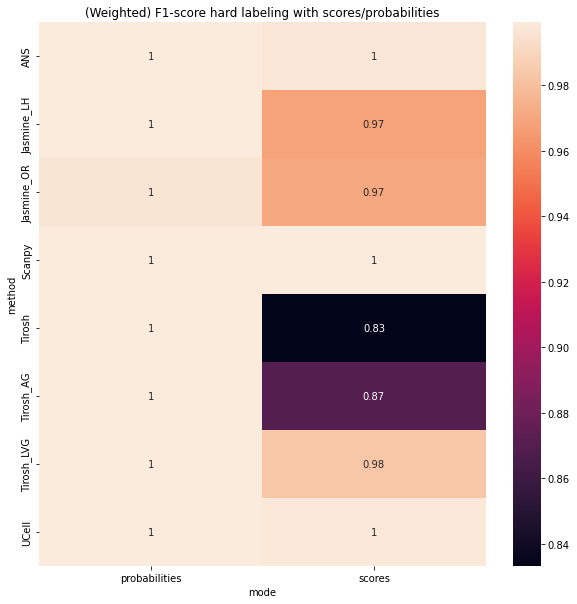

In [25]:
plt.figure(figsize=(10,10))
sns.heatmap(res, annot=True)
plt.title('(Weighted) F1-score hard labeling with scores/probabilities');

### Scenario 2: Two signatures

In [26]:
res = []
for pred_col in all_pred_cols_2:
    splitted = pred_col.rsplit('_',3)
    
    pred = adata.obs[pred_col].copy()
    
    f1sc = f1_score(gt, pred, average='weighted')
    
    res.append({
       'method':splitted[0], 
       'mode':splitted[1],
       'f1-score':f1sc
    })
res = pd.DataFrame(res)
res = res.pivot(index='method', columns='mode', values='f1-score')


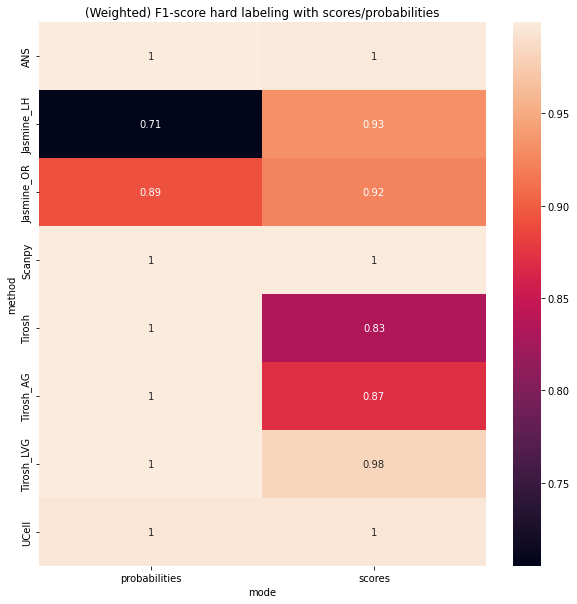

In [27]:
plt.figure(figsize=(10,10))
sns.heatmap(res, annot=True)
plt.title('(Weighted) F1-score hard labeling with scores/probabilities');